# Exploración del Dataset (EDA) – Logos de la Premier League

Este notebook deja documentada una EDA breve para trabajar con capas convolucionales. La idea es entender el dataset antes de modelar y dejar decisiones claras de preprocesamiento.

## Contexto y motivación
En imágenes, las CNN aprovechan localidad y patrones repetidos. Por eso, antes de entrenar, conviene revisar cómo está organizado el dataset y qué decisiones de arquitectura y preprocesamiento se justifican.

Me enfoqué en:
- Entender la estructura del dataset y el CSV de etiquetas.
- Ver distribución de clases y posibles desbalances.
- Revisar tamaños y canales de imagen.
- Mostrar ejemplos por clase para validar etiquetas.
- Proponer preprocesamiento mínimo claro.

## Justificación del dataset
El dataset **English Premier League Logo Detection (20k imágenes)** es adecuado para CNN porque:
- Es visual (imágenes 2D).
- Tiene múltiples clases (logos de equipos).
- El tamaño es manejable en un portátil o notebook en la nube.
- Permite evaluar decisiones de arquitectura en un problema real.

## 1. Dataset Exploration (EDA)

## 1.1 Descarga del dataset
Descargamos el dataset con `kagglehub` y verificamos la ruta local donde quedan los archivos.

In [91]:
import kagglehub

# Descargar la última versión del dataset
path = kagglehub.dataset_download("alexteboul/english-premier-league-logo-detection-20k-images")

print("Ruta a los archivos del dataset:", path)

Ruta a los archivos del dataset: C:\Users\Esteban Aguilera\.cache\kagglehub\datasets\alexteboul\english-premier-league-logo-detection-20k-images\versions\4


## 1.2 Inspección rápida del contenido
Exploramos la estructura del directorio: subcarpetas, archivos y cantidad de imágenes encontradas. Esto ayuda a ubicar el CSV de etiquetas y las rutas de imágenes.

In [92]:
from pathlib import Path

def inspect_dataset_dir(path: str, max_items: int = 20, max_examples: int = 10):
    p = Path(path)

    print(f"Ruta del dataset: {p}")
    print(f"Existe: {p.exists()} | Es directorio: {p.is_dir()}")
    if not p.exists() or not p.is_dir():
        return

    # Top-level: entradas, dirs, files
    entries = list(p.iterdir())
    dirs = sorted([x for x in entries if x.is_dir()], key=lambda x: x.name.lower())
    files = sorted([x for x in entries if x.is_file()], key=lambda x: x.name.lower())

    print(f"\n[Raíz] Entradas: {len(entries)} | Carpetas: {len(dirs)} | Archivos: {len(files)}")
    if dirs:
        print("Carpetas (muestra):", ", ".join(d.name for d in dirs[:max_items]))
    if files:
        print("Archivos (muestra):", ", ".join(f.name for f in files[:max_items]))

    # Búsqueda recursiva de imágenes
    exts = {".png", ".jpg", ".jpeg", ".webp", ".bmp"}
    imgs = [x for x in p.rglob("*") if x.is_file() and x.suffix.lower() in exts]

    print(f"\n[Imágenes] Total (recursivo): {len(imgs)}")
    if imgs:
        print("Ejemplos:", "\n  " + "\n  ".join(str(x) for x in imgs[:max_examples]))
    else:
        print("No se encontraron imágenes en ninguna subcarpeta.")

    # Sugerencia: subcarpeta con más imágenes (candidata)
    if dirs and not imgs:
        print("\nSugerencia: revisa subcarpetas (no se detectaron imágenes).")

    # Si hay imágenes, sugerir subcarpeta principal si no están en raíz
    if imgs and not any(f.suffix.lower() in exts for f in files):
        counts = []
        for d in dirs:
            c = sum(1 for x in d.rglob("*") if x.is_file() and x.suffix.lower() in exts)
            if c:
                counts.append((c, d))
        if counts:
            counts.sort(reverse=True, key=lambda t: t[0])
            c, d = counts[0]
            print(f"\nSubcarpeta candidata: {d} (contiene {c} imágenes)")

# USO
inspect_dataset_dir(path)

Ruta del dataset: C:\Users\Esteban Aguilera\.cache\kagglehub\datasets\alexteboul\english-premier-league-logo-detection-20k-images\versions\4
Existe: True | Es directorio: True

[Raíz] Entradas: 2 | Carpetas: 1 | Archivos: 1
Carpetas (muestra): epl-logos-big
Archivos (muestra): train.csv

[Imágenes] Total (recursivo): 20000
Ejemplos: 
  C:\Users\Esteban Aguilera\.cache\kagglehub\datasets\alexteboul\english-premier-league-logo-detection-20k-images\versions\4\epl-logos-big\epl-logos-big\arsenal\00451122-7e55-4388-a7f1-9c2ba87409c0.png
  C:\Users\Esteban Aguilera\.cache\kagglehub\datasets\alexteboul\english-premier-league-logo-detection-20k-images\versions\4\epl-logos-big\epl-logos-big\arsenal\004fa685-48e5-40a0-9561-05c2f2db6d95.png
  C:\Users\Esteban Aguilera\.cache\kagglehub\datasets\alexteboul\english-premier-league-logo-detection-20k-images\versions\4\epl-logos-big\epl-logos-big\arsenal\009abab7-5542-43d2-957c-b0d28aa33bff.png
  C:\Users\Esteban Aguilera\.cache\kagglehub\datasets\alex

## 1.2.1 Carga de etiquetas y rutas locales
Leemos el CSV de etiquetas y resolvemos rutas locales para las imágenes. Esto habilita la distribución de clases y el muestreo visual.

In [93]:
from pathlib import Path
import pandas as pd

def load_labels_and_paths(dataset_root: str):
    root = Path(dataset_root)
    csvs = list(root.rglob("*.csv"))
    if not csvs:
        raise FileNotFoundError("No se encontraron archivos CSV en el dataset.")

    # Preferir train.csv si existe
    csv_path = next((p for p in csvs if p.name.lower() == "train.csv"), csvs[0])
    df = pd.read_csv(csv_path)
    print(f"CSV seleccionado: {csv_path}")
    print("Columnas:", df.columns.tolist())

    # Indexar imágenes por nombre de archivo
    exts = {".png", ".jpg", ".jpeg", ".webp", ".bmp"}
    image_files = [p for p in root.rglob("*") if p.is_file() and p.suffix.lower() in exts]
    print(f"Imágenes encontradas: {len(image_files)}")
    name_to_path = {}
    for p in image_files:
        name_to_path.setdefault(p.name, p)

    # Resolver columna de paths
    candidate_col = None
    if "filepath" in df.columns:
        candidate_col = "filepath"
    else:
        candidate_col = next((c for c in df.columns if "path" in c.lower() or "file" in c.lower()), None)

    if candidate_col:
        df["local_path"] = df[candidate_col].apply(lambda p: str(name_to_path.get(Path(str(p)).name, "")))
        missing = (df["local_path"] == "").sum()
        print(f"Paths no resueltos: {missing}/{len(df)}")
    else:
        print("No se detectó columna de rutas. Revisa el CSV manualmente.")

    return df, csv_path

# USO
labels_df, labels_csv_path = load_labels_and_paths(path)
labels_df.head()

CSV seleccionado: C:\Users\Esteban Aguilera\.cache\kagglehub\datasets\alexteboul\english-premier-league-logo-detection-20k-images\versions\4\train.csv
Columnas: ['filepath', 'team_name', 'team']
Imágenes encontradas: 20000
Paths no resueltos: 0/20000


,filepath,team_name,team,local_path
0,../input/english-premier-league-logo-detection...,manchester-united,12,C:\Users\Esteban Aguilera\.cache\kagglehub\dat...
1,../input/english-premier-league-logo-detection...,manchester-united,12,C:\Users\Esteban Aguilera\.cache\kagglehub\dat...
2,../input/english-premier-league-logo-detection...,manchester-united,12,C:\Users\Esteban Aguilera\.cache\kagglehub\dat...
3,../input/english-premier-league-logo-detection...,manchester-united,12,C:\Users\Esteban Aguilera\.cache\kagglehub\dat...
4,../input/english-premier-league-logo-detection...,manchester-united,12,C:\Users\Esteban Aguilera\.cache\kagglehub\dat...


## 1.3 Distribución de clases (balance)
Calculamos el número de imágenes por clase para detectar sesgos. Si hay clases con muy pocos ejemplos, el entrenamiento puede volverse inestable y el modelo tenderá a sobre‑ajustar esas clases.

**Qué buscamos:**
- Clases dominantes vs. clases raras.
- Variación extrema entre mínimos y máximos.
- Necesidad de *stratified split* y métricas por clase (precision/recall).

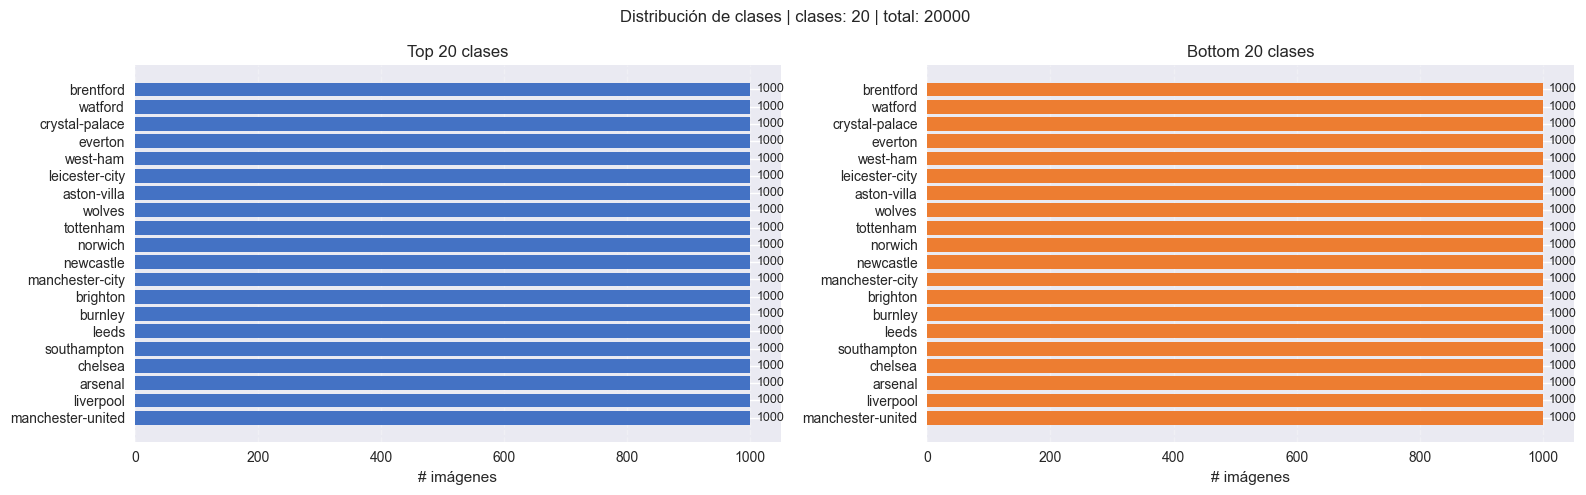

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_labels_13(df: pd.DataFrame, top_n: int = 20, label_col: str = "team_name"):
    vc = df[label_col].value_counts()
    n_classes = df[label_col].nunique()
    total = len(df)

    plt.style.use("seaborn-v0_8")
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    def annotate_bars(ax):
        for p in ax.patches:
            w = p.get_width()
            ax.text(w + max(vc.values) * 0.01, p.get_y() + p.get_height() / 2,
                    f"{int(w)}", va="center", fontsize=9)

    top = vc.head(top_n).sort_values(ascending=True)
    axes[0].barh(top.index, top.values, color="#4472C4")
    axes[0].set_title(f"Top {top_n} clases")
    axes[0].set_xlabel("# imágenes")
    axes[0].grid(axis="x", linestyle="--", alpha=0.3)
    annotate_bars(axes[0])

    bottom = vc.tail(top_n).sort_values(ascending=True)
    axes[1].barh(bottom.index, bottom.values, color="#ED7D31")
    axes[1].set_title(f"Bottom {top_n} clases")
    axes[1].set_xlabel("# imágenes")
    axes[1].grid(axis="x", linestyle="--", alpha=0.3)
    annotate_bars(axes[1])

    fig.suptitle(f"Distribución de clases | clases: {n_classes} | total: {total}")
    plt.tight_layout()
    plt.show()

plot_labels_13(labels_df, top_n=20)

## 1.4 Dimensiones y canales (muestreo)
Muestreamos imágenes para estimar tamaños y modos de color (`RGB`, `RGBA`, `L`).
Esto ayuda a decidir:
- Tamaño de entrada del modelo (p.ej., $224\times224$).
- Si se debe unificar a RGB.
- Si hay *outliers* de tamaño que requieran *resize* o recorte.

Muestra analizada: 500/500 | ilegibles: 0

Resumen tamaños:


,width,height
count,500.000000,500.000000
mean,135.128000,135.128000
std,10.625697,10.625697
min,112.000000,112.000000
25%,140.000000,140.000000
50%,140.000000,140.000000
75%,140.000000,140.000000
max,140.000000,140.000000



Canales (mode) conteo:


mode
RGBA    500
Name: count, dtype: int64

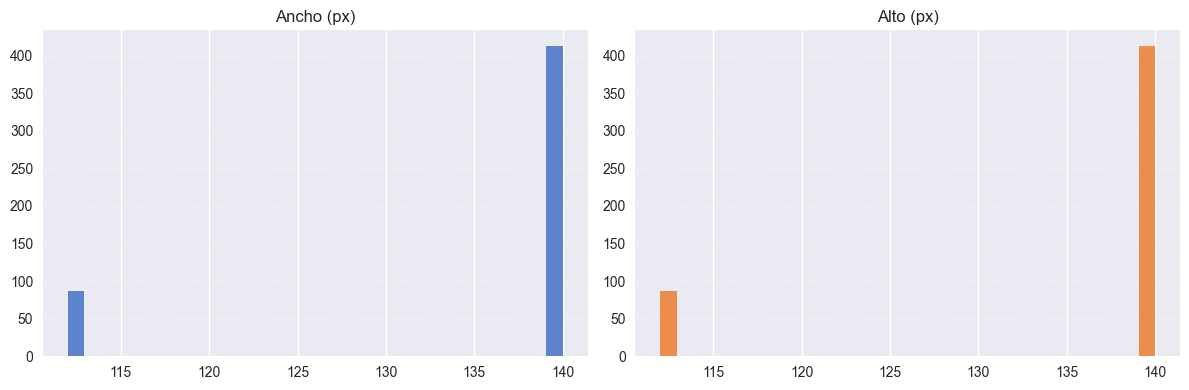

In [95]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

def inspect_images_14(df: pd.DataFrame, path_col: str = "local_path", sample_size: int = 500, seed: int = 42):
    df_ok = df[df[path_col].apply(lambda p: Path(p).exists())].copy()
    if df_ok.empty:
        print(f"No hay paths existentes en columna '{path_col}'.")
        return None

    sample_size = min(sample_size, len(df_ok))
    sample = df_ok.sample(sample_size, random_state=seed)

    widths, heights, modes = [], [], []
    bad = 0

    for p in sample[path_col]:
        try:
            with Image.open(p) as im:
                w, h = im.size
                widths.append(w)
                heights.append(h)
                modes.append(im.mode)
        except Exception:
            bad += 1

    meta = pd.DataFrame({"width": widths, "height": heights, "mode": modes})
    print(f"Muestra analizada: {len(meta)}/{sample_size} | ilegibles: {bad}")
    print("\nResumen tamaños:")
    display(meta[["width", "height"]].describe())
    print("\nCanales (mode) conteo:")
    display(meta["mode"].value_counts())

    plt.style.use("seaborn-v0_8")
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].hist(meta["width"], bins=30, color="#4472C4", alpha=0.85)
    axes[0].set_title("Ancho (px)")
    axes[0].grid(axis="y", linestyle="--", alpha=0.3)

    axes[1].hist(meta["height"], bins=30, color="#ED7D31", alpha=0.85)
    axes[1].set_title("Alto (px)")
    axes[1].grid(axis="y", linestyle="--", alpha=0.3)

    plt.tight_layout()
    plt.show()
    return meta

meta_14 = inspect_images_14(labels_df, path_col="local_path", sample_size=500)

## 1.5 Ejemplos por clase
Visualizamos ejemplos para validar que las etiquetas son coherentes.

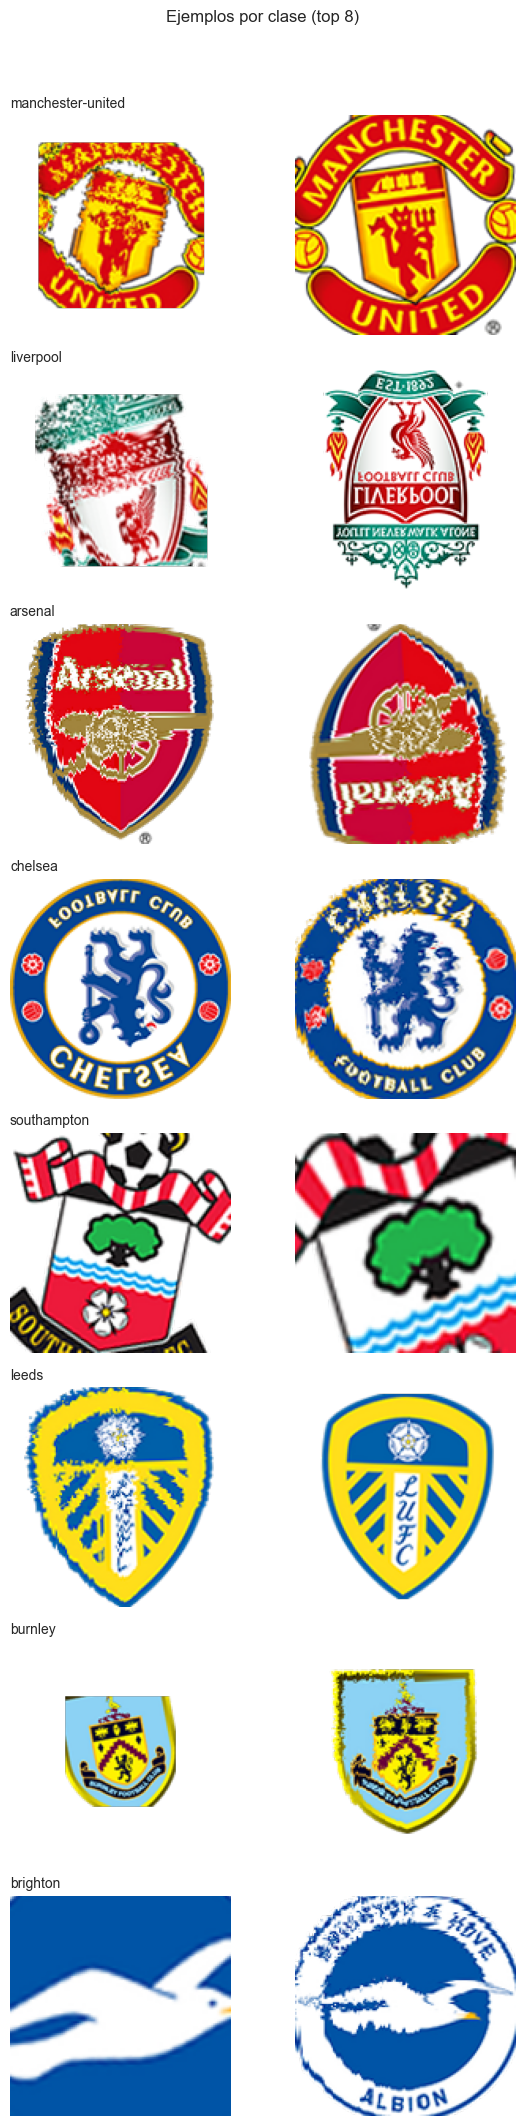

In [96]:
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

def show_examples_15(df: pd.DataFrame, path_col: str = "local_path", label_col: str = "team_name",
                     classes_top_k: int = 8, examples_per_class: int = 2, seed: int = 42):
    df_ok = df[df[path_col].apply(lambda p: Path(p).exists())].copy()
    vc = df_ok[label_col].value_counts()
    classes = list(vc.head(classes_top_k).index)

    rows, cols = len(classes), examples_per_class
    fig, axes = plt.subplots(rows, cols, figsize=(3.2 * cols, 2.6 * rows))
    if rows == 1 and cols == 1:
        axes = [[axes]]
    elif rows == 1:
        axes = [axes]
    elif cols == 1:
        axes = [[ax] for ax in axes]

    for r, cls in enumerate(classes):
        sub = df_ok[df_ok[label_col] == cls].sample(min(examples_per_class, (df_ok[label_col] == cls).sum()),
                                                    random_state=seed)
        sub = sub.reset_index(drop=True)

        for c in range(cols):
            ax = axes[r][c]
            ax.axis("off")

            if c < len(sub):
                img_path = sub.loc[c, path_col]
                with Image.open(img_path) as im:
                    ax.imshow(im)
                title = f"{cls}"
                if c == 0:
                    ax.set_title(title, loc="left", fontsize=10)
            else:
                if c == 0:
                    ax.set_title(f"{cls} (sin más ejemplos)", loc="left", fontsize=10)

    plt.suptitle(f"Ejemplos por clase (top {classes_top_k})", y=1.02)
    plt.tight_layout()
    plt.show()

# USO
show_examples_15(labels_df, classes_top_k=8, examples_per_class=2)

## 1.7 Conclusiones (EDA)

> **Cómo leer esta sección:** completa los valores reales con el resumen automático de la celda 1.7.1.

**Hallazgos clave (claros y accionables)**
- **Tamaño y clases:** $N$ imágenes en $C$ clases. Si el desbalance es alto (ratio max/min elevado), usar **split estratificado** y reportar **precision/recall** por clase.
- **Dimensiones y canales:** hay variación en tamaño y posibles modos (`RGB`, `RGBA`). Se recomienda **convertir a RGB** y **redimensionar** a tamaño fijo.
- **Impacto en CNN:** tamaños heterogéneos obligan a *resize*; canales inconsistentes requieren normalización. Esto mejora estabilidad y convergencia.

**Preprocesamiento mínimo recomendado**
1) Convertir a **RGB**.
2) **Resize** a $224\times224$ (o $256\times256$ si se prioriza detalle).
3) **Normalización** (0–1 o stats de ImageNet si hay *transfer learning*).
4) **Augmentations suaves** en entrenamiento (flip horizontal, crop, jitter leve).

**Siguiente paso**
Definir `Dataset/Dataloader`, construir un **baseline CNN** y comparar variantes de arquitectura (kernel, profundidad, stride).

In [97]:
from pathlib import Path
import pandas as pd
from IPython.display import Markdown, display

def eda_summary_17(labels_df: pd.DataFrame,
                   meta_14: pd.DataFrame | None = None,
                   label_col: str = "team_name",
                   id_col: str = "team",
                   path_col: str = "local_path",
                   top_n: int = 5):
    display(Markdown("### Resumen EDA (1.7)"))

    total = len(labels_df)
    display(Markdown(f"- **Total de filas (CSV):** {total}"))

    if path_col in labels_df.columns:
        exists = labels_df[path_col].apply(lambda p: Path(p).exists())
        display(Markdown(f"- **Paths existentes:** {int(exists.sum())}/{total} ({exists.mean():.2%})"))

    if label_col in labels_df.columns:
        n_classes = labels_df[label_col].nunique()
        vc = labels_df[label_col].value_counts()
        imbalance_ratio = vc.max() / vc.min() if vc.min() > 0 else float("inf")
        display(Markdown(f"- **Clases únicas:** {n_classes}"))
        display(Markdown(f"- **Imgs/clase (promedio | min | max):** {vc.mean():.1f} | {vc.min()} | {vc.max()}"))
        display(Markdown(f"- **Imbalance (max/min):** {imbalance_ratio:.2f}"))
        display(Markdown(f"- **Top {top_n} clases:**"))
        display(vc.head(top_n).to_frame(name="#imágenes"))
        display(Markdown(f"- **Bottom {top_n} clases:**"))
        display(vc.tail(top_n).to_frame(name="#imágenes"))

    if {label_col, id_col}.issubset(labels_df.columns):
        mapping = labels_df.groupby(label_col)[id_col].nunique()
        bad = mapping[mapping > 1]
        display(Markdown(f"- **Consistencia {label_col} → {id_col}:** problemas={len(bad)}"))
        if len(bad):
            display(bad.sort_values(ascending=False).head(10))

    if meta_14 is not None and not meta_14.empty:
        display(Markdown("- **Tamaños (muestra):**"))
        size_cols = [c for c in ["width", "height", "aspect_ratio"] if c in meta_14.columns]
        if size_cols:
            display(meta_14[size_cols].describe())
        if "mode" in meta_14.columns:
            display(Markdown("- **Canales (mode):**"))
            display(meta_14["mode"].value_counts().to_frame(name="#imágenes"))

eda_summary_17(labels_df, meta_14=meta_14)

### Resumen EDA (1.7)

- **Total de filas (CSV):** 20000

- **Paths existentes:** 20000/20000 (100.00%)

- **Clases únicas:** 20

- **Imgs/clase (promedio | min | max):** 1000.0 | 1000 | 1000

- **Imbalance (max/min):** 1.00

- **Top 5 clases:**

,#imágenes
team_name,
manchester-united,1000
liverpool,1000
arsenal,1000
chelsea,1000
southampton,1000


- **Bottom 5 clases:**

,#imágenes
team_name,
west-ham,1000
everton,1000
crystal-palace,1000
watford,1000
brentford,1000


- **Consistencia team_name → team:** problemas=0

- **Tamaños (muestra):**

,width,height
count,500.000000,500.000000
mean,135.128000,135.128000
std,10.625697,10.625697
min,112.000000,112.000000
25%,140.000000,140.000000
50%,140.000000,140.000000
75%,140.000000,140.000000
max,140.000000,140.000000


- **Canales (mode):**

,#imágenes
mode,
RGBA,500


## 2. Baseline Model (sin convolución)
Modelo de referencia con capas densas. Sirve como punto de comparación frente a CNN.

### 2.1 Preparación de datos
Carga, normalización y split train/val.

In [98]:
import numpy as np
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

np.random.seed(42)

def load_images_from_df(df, path_col="local_path", label_col="team_name", target_size=(96, 96), max_samples=2000):
    df_ok = df[df[path_col].apply(lambda p: Path(p).exists())].copy()
    if max_samples and len(df_ok) > max_samples:
        df_ok = df_ok.sample(max_samples, random_state=42)

    X = []
    y = []
    for p, label in zip(df_ok[path_col], df_ok[label_col]):
        with Image.open(p) as im:
            im = im.convert("RGB").resize(target_size)
            X.append(np.asarray(im, dtype=np.float32) / 255.0)
            y.append(label)

    X = np.stack(X, axis=0).reshape(len(X), -1)
    le = LabelEncoder()
    y_enc = le.fit_transform(y)

    return X, y_enc, le

X, y, label_encoder = load_images_from_df(labels_df, target_size=(96, 96), max_samples=2000)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
 )

X_train.shape, X_val.shape

((1600, 27648), (400, 27648))

### 2.2 Arquitectura y entrenamiento
Modelo denso base, entrenamiento y evaluación.

In [99]:
from sklearn.neural_network import MLPClassifier

num_classes = len(np.unique(y_train))
model = MLPClassifier(
    hidden_layer_sizes=(128,),
    activation="relu",
    solver="adam",
    batch_size=64,
    max_iter=5,
    early_stopping=True,
    n_iter_no_change=2,
    random_state=42
 )

model

,"hidden_layer_sizes hidden_layer_sizes: array-like of shape(n_layers - 2,), default=(100,)The ith element represents the number of neurons in the ithhidden layer.","(128,)"
,"activation activation: {'identity', 'logistic', 'tanh', 'relu'}, default='relu'Activation function for the hidden layer.- 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x- 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).- 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).- 'relu', the rectified linear unit function, returns f(x) = max(0, x)",'relu'
,"solver solver: {'lbfgs', 'sgd', 'adam'}, default='adam'The solver for weight optimization.- 'lbfgs' is an optimizer in the family of quasi-Newton methods.- 'sgd' refers to stochastic gradient descent.- 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy BaFor a comparison between Adam optimizer and SGD, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_training_curves.py`.Note: The default solver 'adam' works pretty well on relativelylarge datasets (with thousands of training samples or more) in terms ofboth training time and validation score.For small datasets, however, 'lbfgs' can converge faster and performbetter.",'adam'
,"alpha alpha: float, default=0.0001Strength of the L2 regularization term. The L2 regularization termis divided by the sample size when added to the loss.For an example usage and visualization of varying regularization, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_alpha.py`.",0.0001
,"batch_size batch_size: int, default='auto'Size of minibatches for stochastic optimizers.If the solver is 'lbfgs', the classifier will not use minibatch.When set to ""auto"", `batch_size=min(200, n_samples)`.",64
,"learning_rate learning_rate: {'constant', 'invscaling', 'adaptive'}, default='constant'Learning rate schedule for weight updates.- 'constant' is a constant learning rate given by 'learning_rate_init'.- 'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of 'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)- 'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.Only used when ``solver='sgd'``.",'constant'
,"learning_rate_init learning_rate_init: float, default=0.001The initial learning rate used. It controls the step-sizein updating the weights. Only used when solver='sgd' or 'adam'.",0.001
,"power_t power_t: float, default=0.5The exponent for inverse scaling learning rate.It is used in updating effective learning rate when the learning_rateis set to 'invscaling'. Only used when solver='sgd'.",0.5
,"max_iter max_iter: int, default=200Maximum number of iterations. The solver iterates until convergence(determined by 'tol') or this number of iterations. For stochasticsolvers ('sgd', 'adam'), note that this determines the number of epochs(how many times each data point will be used), not the number ofgradient steps.",5
,"shuffle shuffle: bool, default=TrueWhether to shuffle samples in each iteration. Only used whensolver='sgd' or 'adam'.",True
,"random_state random_state: int, RandomState instance, default=NoneDetermines random number generation for weights and biasinitialization, train-test split if early stopping is used, and batchsampling when solver='sgd' or 'adam'.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42


In [100]:
from sklearn.metrics import accuracy_score, log_loss

model.fit(X_train, y_train)

train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

train_acc = accuracy_score(y_train, train_pred)
val_acc = accuracy_score(y_val, val_pred)

train_proba = model.predict_proba(X_train)
val_proba = model.predict_proba(X_val)

train_loss = log_loss(y_train, train_proba)
val_loss = log_loss(y_val, val_proba)

train_acc, val_acc

C:\Users\Esteban Aguilera\AppData\Roaming\Python\Python314\site-packages\sklearn\neural_network\_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


(0.94125, 0.8675)

In [101]:
from IPython.display import Markdown, display

param_count = sum(w.size for w in model.coefs_) + sum(b.size for b in model.intercepts_)
gap = train_acc - val_acc

display(Markdown("### Reporte del baseline"))
display(Markdown(f"- **Arquitectura:** Flatten → Dense(256) → Dense({num_classes})"))
display(Markdown(f"- **Parámetros:** {param_count:,}"))
display(Markdown(f"- **Train:** acc={train_acc:.3f}, loss={train_loss:.3f}"))
display(Markdown(f"- **Val:** acc={val_acc:.3f}, loss={val_loss:.3f}"))

if gap > 0.05:
    display(Markdown("- **Observación:** posible sobreajuste (gap train/val notable)."))
else:
    display(Markdown("- **Observación:** gap train/val moderado."))

### Reporte del baseline

- **Arquitectura:** Flatten → Dense(256) → Dense(20)

- **Parámetros:** 3,541,652

- **Train:** acc=0.941, loss=0.362

- **Val:** acc=0.868, loss=0.628

- **Observación:** posible sobreajuste (gap train/val notable).

**Limitaciones observadas (baseline denso)**
- No explota estructura espacial; depende de *flatten* y pierde localidad.
- Requiere más parámetros para capturar patrones visuales.
- Sensible al *resize* y al desbalance de clases.
- Generaliza peor que una CNN en tareas de imagen.

## 3. Convolutional Architecture Design
Arquitectura CNN sencilla y justificada para clasificación de logos.

### 3.1 Decisiones de diseño (justificación)
- **N.º de capas conv:** 3 bloques para capturar bordes → patrones medios → detalles de logos.
- **Kernel:** $3\times3$ en todas las capas para mantener localidad y eficiencia.
- **Stride y padding:** stride $1$ y padding $1$ para conservar resolución dentro de cada bloque.
- **Activación:** ReLU por estabilidad y costo computacional bajo.
- **Pooling:** MaxPool $2\times2$ al final de cada bloque para reducir dimensión y ganar invariancia espacial.

In [102]:
input_size = 96
num_classes = 20

def conv_params(k, in_ch, out_ch, bias=True):
    return (k * k * in_ch + (1 if bias else 0)) * out_ch

layers = [
    {"type": "conv", "k": 3, "in_ch": 3, "out_ch": 32},
    {"type": "pool", "k": 2},
    {"type": "conv", "k": 3, "in_ch": 32, "out_ch": 64},
    {"type": "pool", "k": 2},
    {"type": "conv", "k": 3, "in_ch": 64, "out_ch": 128},
    {"type": "pool", "k": 2},
]

size = input_size
params = 0
for layer in layers:
    if layer["type"] == "conv":
        params += conv_params(layer["k"], layer["in_ch"], layer["out_ch"])
    elif layer["type"] == "pool":
        size //= layer["k"]

flatten = 128 * size * size
params += flatten * 256 + 256
params += 256 * num_classes + num_classes

params

4817236

## 4. Experimentos controlados (capa convolucional)
Se varía **solo el tamaño del kernel** (3×3 vs 5×5). Todo lo demás se mantiene fijo.

### 4.1 Setup
Entrenamiento rápido con subconjunto para comparar kernels 3×3 vs 5×5.

In [103]:
import numpy as np
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#### 4.1.1 Dataset y DataLoader

In [104]:
class LogoDataset(Dataset):
    def __init__(self, df, label_encoder, path_col="local_path", label_col="team_name", size=64):
        self.paths = df[path_col].tolist()
        self.labels = label_encoder.transform(df[label_col].tolist())
        self.size = size

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        with Image.open(p) as im:
            im = im.convert("RGB").resize((self.size, self.size))
            x = np.asarray(im, dtype=np.float32) / 255.0
        x = torch.tensor(x).permute(2, 0, 1)
        y = torch.tensor(self.labels[idx]).long()
        return x, y

#### 4.1.2 Modelo y entrenamiento

In [105]:
def build_cnn(num_classes, kernel_size=3):
    padding = kernel_size // 2
    return nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=kernel_size, padding=padding),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, kernel_size=kernel_size, padding=padding),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(64 * 16 * 16, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, num_classes),
    )

def train_eval(model, train_loader, val_loader, epochs=2, lr=1e-3, device="cpu"):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()

    def eval_loader(loader):
        model.eval()
        total, correct, loss_sum = 0, 0, 0.0
        with torch.no_grad():
            for xb, yb in loader:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = loss_fn(logits, yb)
                preds = logits.argmax(dim=1)
                total += yb.size(0)
                correct += (preds == yb).sum().item()
                loss_sum += loss.item() * yb.size(0)
        return loss_sum / total, correct / total

    train_loss, train_acc = eval_loader(train_loader)
    val_loss, val_acc = eval_loader(val_loader)
    return train_loss, train_acc, val_loss, val_acc

#### 4.1.3 Ejecución del experimento

In [106]:
import pandas as pd
from pathlib import Path

try:
    path
except NameError:
    import kagglehub
    path = kagglehub.dataset_download("alexteboul/english-premier-league-logo-detection-20k-images")

try:
    labels_df
except NameError:
    root = Path(path)
    csvs = list(root.rglob("*.csv"))
    if not csvs:
        raise FileNotFoundError("No se encontraron archivos CSV en el dataset.")
    csv_path = next((p for p in csvs if p.name.lower() == "train.csv"), csvs[0])
    labels_df = pd.read_csv(csv_path)

    exts = {".png", ".jpg", ".jpeg", ".webp", ".bmp"}
    image_files = [p for p in root.rglob("*") if p.is_file() and p.suffix.lower() in exts]
    name_to_path = {p.name: p for p in image_files}
    candidate_col = "filepath" if "filepath" in labels_df.columns else None
    if not candidate_col:
        candidate_col = next((c for c in labels_df.columns if "path" in c.lower() or "file" in c.lower()), None)
    if candidate_col:
        labels_df["local_path"] = labels_df[candidate_col].apply(lambda p: str(name_to_path.get(Path(str(p)).name, "")))

df_ok = labels_df[labels_df["local_path"].apply(lambda p: Path(p).exists())].copy()
df_ok = df_ok.sample(min(1200, len(df_ok)), random_state=42)
train_df, val_df = train_test_split(
    df_ok, test_size=0.2, random_state=42, stratify=df_ok["team_name"]
 )

num_classes = len(label_encoder.classes_) if "label_encoder" in globals() else df_ok["team_name"].nunique()
if "label_encoder" not in globals():
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    label_encoder.fit(df_ok["team_name"].tolist())

train_ds = LogoDataset(train_df, label_encoder, size=64)
val_ds = LogoDataset(val_df, label_encoder, size=64)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

results = []
for k in [3, 5]:
    model = build_cnn(num_classes, kernel_size=k)
    train_loss, train_acc, val_loss, val_acc = train_eval(
        model, train_loader, val_loader, epochs=2
    )
    params = sum(p.numel() for p in model.parameters())
    results.append({
        "kernel": f"{k}x{k}",
        "params": params,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "train_loss": train_loss,
        "val_loss": val_loss
    })

results_df = pd.DataFrame(results)
results_df

,kernel,params,train_acc,val_acc,train_loss,val_loss
0,3x3,2119252,0.912500,0.891667,0.427158,0.483663
1,5x5,2153556,0.914583,0.875000,0.366883,0.441986


### 4.2 Observaciones y trade-offs
- Kernel 3×3 suele ser más eficiente y estable en datasets pequeños.
- Kernel 5×5 aumenta el costo y puede mejorar o no la validación dependiendo del ruido.
- A igual número de filtros, kernels más grandes incrementan parámetros y tiempo de entrenamiento.

## 5. Interpretación y razonamiento arquitectónico
**¿Por qué las capas convolucionales superan (o no) al baseline?**
En imágenes, los patrones útiles son locales y se repiten (bordes, texturas, partes de un logo). Una CNN explota esa estructura con filtros compartidos y menos parámetros. El baseline denso pierde la localidad al hacer *flatten*, necesita más parámetros y tiende a generalizar peor con el mismo tamaño de datos. Si la mejora no aparece, suele ser por poco entrenamiento, bajo tamaño de muestra o un preprocesamiento inadecuado.

**¿Qué sesgo inductivo introduce la convolución?**
Localidad y equivariancia a traslaciones: un patrón detectado en una posición puede detectarse en cualquier otra con el mismo filtro. Además, el *pooling* agrega invariancia parcial y reduce sensibilidad a pequeñas variaciones.

**¿Cuándo no es apropiada la convolución?**
Cuando no hay estructura espacial o local (datos tabulares, series muy cortas sin correlación espacial, vectores ya compactos). También es menos adecuada cuando la relación relevante es global y no local, o cuando la entrada no tiene una topología de vecindad clara.

## 6. Entrenamiento y exportación del modelo (SageMaker)
En esta sección se entrena el modelo y se guarda el archivo para subirlo a SageMaker.

### 6.1 Entrenamiento rápido
Se usa el mismo CNN de la sección 4 con un entrenamiento corto para generar el archivo del modelo.

In [107]:
import os
from pathlib import Path
import torch
import torch.nn as nn

def ensure_loaders():
    if "train_loader" in globals() and "val_loader" in globals():
        return train_loader, val_loader
    df_ok = labels_df[labels_df["local_path"].apply(lambda p: Path(p).exists())].copy()
    df_ok = df_ok.sample(min(1200, len(df_ok)), random_state=42)
    train_df, val_df = train_test_split(
        df_ok, test_size=0.2, random_state=42, stratify=df_ok["team_name"]
    )
    if "label_encoder" not in globals():
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        le.fit(df_ok["team_name"].tolist())
        globals()["label_encoder"] = le
    train_ds = LogoDataset(train_df, label_encoder, size=64)
    val_ds = LogoDataset(val_df, label_encoder, size=64)
    return DataLoader(train_ds, batch_size=32, shuffle=True), DataLoader(val_ds, batch_size=32, shuffle=False)

train_loader, val_loader = ensure_loaders()

num_classes = len(label_encoder.classes_)
model = build_cnn(num_classes, kernel_size=3)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

model.train()
for _ in range(3):
    for xb, yb in train_loader:
        opt.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()

"Entrenamiento listo"

'Entrenamiento listo'

### 6.2 Guardar el modelo
Se guarda el archivo `.pt` para subirlo luego a SageMaker.

In [108]:
output_dir = Path("models")
output_dir.mkdir(parents=True, exist_ok=True)

model_path = output_dir / "cnn_logo_baseline.pt"
torch.save(model.state_dict(), model_path)
model_path.as_posix()

'models/cnn_logo_baseline.pt'

### 6.3 inference.py (SageMaker PyTorch)
Contenido completo del archivo `inference.py` (arquitectura + handlers).



In [ ]:
import base64
import io
import json
import os
from typing import Any, Dict, List, Tuple

import numpy as np
from PIL import Image
import torch
import torch.nn as nn


INPUT_SIZE = 64
KERNEL_SIZE = 3
DROPOUT = 0.3


class CNNLogo(nn.Module):
    def __init__(
        self,
        num_classes: int,
        kernel_size: int = KERNEL_SIZE,
        input_size: int = INPUT_SIZE,
        dropout: float = DROPOUT,
    ) -> None:
        super().__init__()
        padding = kernel_size // 2

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        flattened = 64 * (input_size // 4) * (input_size // 4)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        return self.classifier(x)


def build_cnn(num_classes: int, kernel_size: int = KERNEL_SIZE, input_size: int = INPUT_SIZE, dropout: float = DROPOUT) -> nn.Module:
    padding = kernel_size // 2
    return nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=kernel_size, padding=padding),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, kernel_size=kernel_size, padding=padding),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(64 * (input_size // 4) * (input_size // 4), 128),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(128, num_classes),
    )


def _decode_base64_image(b64_str: str, size: Tuple[int, int] = (INPUT_SIZE, INPUT_SIZE)) -> np.ndarray:
    raw = base64.b64decode(b64_str)
    with Image.open(io.BytesIO(raw)) as im:
        im = im.convert("RGB").resize(size)
        arr = np.asarray(im, dtype=np.float32) / 255.0
    return arr


def _ensure_nchw(arr: np.ndarray) -> np.ndarray:
    if arr.ndim == 3:
        arr = np.expand_dims(arr, axis=0)
        if arr.shape[-1] in (1, 3):
            arr = np.transpose(arr, (0, 3, 1, 2))
    elif arr.ndim == 4:
        if arr.shape[-1] in (1, 3):
            arr = np.transpose(arr, (0, 3, 1, 2))
    else:
        raise ValueError("El input debe ser 3D o 4D.")
    return arr


def _infer_num_classes(state_dict: Dict[str, torch.Tensor]) -> int:
    if "classifier.4.weight" in state_dict:
        return state_dict["classifier.4.weight"].shape[0]

    last_linear = None
    for key, tensor in state_dict.items():
        if key.endswith(".weight") and tensor.ndim == 2:
            last_linear = tensor

    if last_linear is None:
        raise KeyError("No se pudo inferir num_classes desde el state_dict.")

    return last_linear.shape[0]


def model_fn(model_dir: str) -> nn.Module:
    model_path = os.path.join(model_dir, "cnn_logo_baseline.pt")
    state = torch.load(model_path, map_location="cpu")
    num_classes = _infer_num_classes(state)
    if any(k.startswith("0.") for k in state.keys()):
        model = build_cnn(num_classes=num_classes)
    else:
        model = CNNLogo(num_classes=num_classes)
    model.load_state_dict(state, strict=True)
    model.eval()
    return model


def input_fn(request_body: str, content_type: str) -> torch.Tensor:
    if content_type != "application/json":
        raise ValueError(f"content_type no soportado: {content_type}")

    payload = json.loads(request_body)

    if isinstance(payload, dict) and "instances" in payload:
        data = np.array(payload["instances"], dtype=np.float32)
    elif isinstance(payload, dict) and "image" in payload:
        data = _decode_base64_image(payload["image"])
    elif isinstance(payload, dict) and "images" in payload:
        data = np.stack([_decode_base64_image(b) for b in payload["images"]], axis=0)
    else:
        raise ValueError("El JSON debe contener 'instances', 'image' o 'images'.")

    if data.max() > 1.0:
        data = data / 255.0

    data = _ensure_nchw(data)
    return torch.tensor(data, dtype=torch.float32)


def predict_fn(input_data: torch.Tensor, model: nn.Module) -> List[Dict[str, Any]]:
    with torch.no_grad():
        logits = model(input_data)
        probs = torch.softmax(logits, dim=1)
        top_probs, top_idx = torch.max(probs, dim=1)

    results = []
    for cls_id, prob in zip(top_idx.tolist(), top_probs.tolist()):
        results.append({"class_id": int(cls_id), "prob": float(prob)})
    return results


def output_fn(prediction: List[Dict[str, Any]], accept: str) -> str:
    if accept != "application/json":
        raise ValueError(f"accept no soportado: {accept}")
    return json.dumps({"predictions": prediction})

### 6.4 Script para generar model.tar.gz
Contenido completo del script `make_model_tar.py` (empaqueta `cnn_logo_baseline.pt` + `inference.py`).

```python
import argparse
import tarfile
import tempfile
from pathlib import Path


def make_tar(model_path: Path, inference_path: Path, output_path: Path) -> None:
    if not model_path.exists():
        raise FileNotFoundError(f"No existe el modelo: {model_path}")
    if not inference_path.exists():
        raise FileNotFoundError(f"No existe inference.py: {inference_path}")

    with tempfile.TemporaryDirectory() as tmp_dir:
        tmp_root = Path(tmp_dir)
        code_dir = tmp_root / "code"
        code_dir.mkdir(parents=True, exist_ok=True)

        # Copiar archivos
        (tmp_root / model_path.name).write_bytes(model_path.read_bytes())
        (code_dir / "inference.py").write_bytes(inference_path.read_bytes())

        with tarfile.open(output_path, "w:gz") as tar:
            tar.add(tmp_root / model_path.name, arcname=model_path.name)
            tar.add(code_dir / "inference.py", arcname="code/inference.py")


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Empaquetar modelo PyTorch para SageMaker")
    parser.add_argument("--model-path", default="models/cnn_logo_baseline.pt")
    parser.add_argument("--inference-path", default="inference.py")
    parser.add_argument("--output", default="model.tar.gz")
    args = parser.parse_args()

    make_tar(Path(args.model_path), Path(args.inference_path), Path(args.output))
    print(f"Archivo generado: {args.output}")
```

### 6.5 Generar model.tar.gz
Ejecuta este paso para crear el archivo `model.tar.gz` localmente (sin usar endpoints, estimators ni S3).

In [ ]:
from pathlib import Path
from make_model_tar import make_tar

make_tar(
    model_path=Path("models/cnn_logo_baseline.pt"),
    inference_path=Path("models/inference.py"),
    output_path=Path("models/model.tar.gz"),
)

"model.tar.gz generado"

'model.tar.gz generado'

### 6.6 Prueba local 
Se carga el modelo exportado y se hace una predicción con una imagen real del dataset.

In [118]:
from pathlib import Path
import base64
import json
import importlib.util

# Cargar inference.py desde la carpeta models
inference_path = Path("models") / "inference.py"
if not inference_path.exists():
    raise FileNotFoundError("No existe models/inference.py en el proyecto.")

spec = importlib.util.spec_from_file_location("inference", inference_path)
inference = importlib.util.module_from_spec(spec)
spec.loader.exec_module(inference)

model_fn = inference.model_fn
input_fn = inference.input_fn
predict_fn = inference.predict_fn
output_fn = inference.output_fn

# Tomar una imagen real del dataset
sample_path = next((Path(p) for p in labels_df["local_path"] if Path(p).exists()), None)
if sample_path is None:
    raise FileNotFoundError("No se encontró una imagen válida en labels_df['local_path'].")

img_b64 = base64.b64encode(sample_path.read_bytes()).decode("utf-8")
payload = json.dumps({"image": img_b64})

# Cargar modelo (archivo en models/cnn_logo_baseline.pt)
model = model_fn("models")
input_tensor = input_fn(payload, "application/json")
pred = predict_fn(input_tensor, model)
result = output_fn(pred, "application/json")

{"sample": sample_path.as_posix(), "result": result}

{'sample': 'C:/Users/Esteban Aguilera/.cache/kagglehub/datasets/alexteboul/english-premier-league-logo-detection-20k-images/versions/4/epl-logos-big/epl-logos-big/manchester-united/49fe842f-b0b8-41a8-9751-1bc2890751b6.png',
 'result': '{"predictions": [{"class_id": 12, "prob": 0.9964264035224915}]}'}

### 6.7 Conclusiones (prueba local)
- La inferencia local funciona: se carga el modelo, se procesa una imagen real y se obtiene una predicción válida.
- La salida devuelve `class_id` y probabilidad; un valor alto (≈0.996) indica alta confianza para esa muestra.
- El flujo de empaquetado + `inference.py` es compatible para uso posterior en SageMaker (sin desplegar ahora).
- Si se requiere interpretar el `class_id`, hay que mapearlo con el `LabelEncoder` usado en entrenamiento.